In [1]:
# DLPFC Sample1 & Sample3 — Preprocessing + Ground Truth Visualization
# Step 1 of the GASTON analysis pipeline

# ============================================
# Part 1: Import libraries
# ============================================

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from collections import defaultdict

from gaston import cluster_plotting   # for canonical ground truth plots

# Global plot settings
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

print("Libraries imported.")

Libraries imported.


In [2]:
# ============================================
# Part 2: Set paths and parameters
# ============================================

# Base paths
BASE_DIR = '/home/siruilf/A_new_dataset_for_gaston'
OUTPUT_DIR = f'{BASE_DIR}/DLPFC_gaston_outputs'

# Sample1 slice IDs (151507-151510)
SAMPLE1_SLICES = ['151507', '151508', '151509', '151510']
SAMPLE1_DATA_DIR = f'{BASE_DIR}/ST_Data/DLPFC_sample1/original_data'

# Sample3 slice IDs (151673-151676)
SAMPLE3_SLICES = ['151673', '151674', '151675', '151676']
SAMPLE3_DATA_DIR = f'{BASE_DIR}/ST_Data/DLPFC_sample3/original_data'

# Integer label mapping — consistent with Process_NN_Output pipeline
LABEL_TO_INT = {
    'L1': 0, 'L2': 1, 'L3': 2,
    'L4': 3, 'L5': 4, 'L6': 5,
    'WM': 6, 'nan': 7,
}
INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}

print("Paths and parameters configured.")
print(f"Output directory: {OUTPUT_DIR}")

Paths and parameters configured.
Output directory: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs


In [3]:
# ============================================
# Part 3: Create output directory structure
# ============================================

folders_to_create = [
    f'{OUTPUT_DIR}/sample1/ground_truth_plots',
    f'{OUTPUT_DIR}/sample1/preprocessed_data',
    f'{OUTPUT_DIR}/sample3/ground_truth_plots',
    f'{OUTPUT_DIR}/sample3/preprocessed_data',
]

for folder in folders_to_create:
    os.makedirs(folder, exist_ok=True)
    print(f"Created/verified: {folder}")

print("\nDirectory structure ready.")

Created/verified: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots
Created/verified: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/preprocessed_data
Created/verified: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots
Created/verified: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/preprocessed_data

Directory structure ready.


In [4]:
# ============================================
# Part 4: Define data loading and plotting functions
# ============================================

def load_slice_data(slice_id, data_dir):
    """Load h5ad data for a single tissue slice."""
    return sc.read_h5ad(f'{data_dir}/{slice_id}.h5ad')


def _prepare(adata):
    """
    Return normalized spatial coordinates S and integer labels,
    matching the format used in the Process_NN_Output pipeline.

    S          : ndarray (n_spots, 2), normalized to [0, 1]
    labels_int : ndarray (n_spots,),  integer labels L1=0 … WM=6, nan=7
    label_names: list[str], ordered by ascending integer value,
                 for use as the `labels` argument of plot_clusters
    """
    coords = adata.obsm['spatial'].astype(float)
    S = (coords - coords.min(axis=0)) / (coords.max(axis=0) - coords.min(axis=0))

    raw        = adata.obs['original_domain'].astype(str).values
    labels_int = np.array([LABEL_TO_INT.get(l, 7) for l in raw])

    # Build label-name list in the same order as np.unique(labels_int)
    label_names = [INT_TO_LABEL[t] for t in np.unique(labels_int)]
    return S, labels_int, label_names


def plot_ground_truth_single(adata, slice_id, sample_name, save_path=None):
    """
    Plot ground truth for one slice using gaston's cluster_plotting —
    identical style to the Process_NN_Output pipeline.
    """
    S, labels_int, label_names = _prepare(adata)

    # Create fig+ax first and pass them in — avoids cluster_plotting
    # opening a second figure internally.
    fig, ax = plt.subplots(figsize=(6, 6))
    cluster_plotting.plot_clusters(
        labels_int, S,
        fig=fig, ax=ax,
        color_palette=plt.cm.tab10,
        s=10,
        labels=label_names,
        lgd=True,
    )
    ax.set_title(f'{slice_id} Ground Truth', fontsize=14, fontweight='bold')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()
    plt.close()


def plot_ground_truth_grid(adata_dict, sample_name, save_path=None):
    """
    Plot all slices side-by-side.  Each panel is produced by
    cluster_plotting.plot_clusters with the pre-created ax passed in,
    so the subplots are not blank.
    """
    n = len(adata_dict)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
    if n == 1:
        axes = [axes]

    items = list(adata_dict.items())
    for idx, (ax, (slice_id, adata)) in enumerate(zip(axes, items)):
        S, labels_int, label_names = _prepare(adata)

        cluster_plotting.plot_clusters(
            labels_int, S,
            fig=fig, ax=ax,          # KEY: pass existing axes — no blank boxes
            color_palette=plt.cm.tab10,
            s=8,
            labels=label_names,
            lgd=(idx == n - 1),      # legend only on the last panel
        )
        ax.set_title(f'{slice_id} Ground Truth', fontsize=12, fontweight='bold')

    plt.suptitle(f'DLPFC {sample_name}', fontsize=13, fontweight='bold', y=1.01)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()
    plt.close()


def print_slice_statistics(adata_dict, sample_name):
    """Print spot counts and label distribution for each slice."""
    print(f"\n{'='*60}")
    print(f"DLPFC {sample_name} — Data Summary")
    print(f"{'='*60}")
    total_spots = 0
    for slice_id, adata in adata_dict.items():
        labels = adata.obs['original_domain'].astype(str).values
        label_counts = dict(zip(*np.unique(labels, return_counts=True)))
        print(f"\nSlice {slice_id}: {len(labels)} spots")
        print(f"  Label distribution: {label_counts}")
        total_spots += len(labels)
    print(f"\nTotal: {total_spots} spots")
    print(f"{'='*60}")


print("Functions defined.")

Functions defined.


In [5]:
# ============================================
# Part 5: Load Sample1 data
# ============================================

print("Loading DLPFC Sample1 data...")
print("-" * 40)

sample1_adata_dict = {}
for slice_id in SAMPLE1_SLICES:
    print(f"Loading slice: {slice_id}")
    sample1_adata_dict[slice_id] = load_slice_data(slice_id, SAMPLE1_DATA_DIR)

print_slice_statistics(sample1_adata_dict, "Sample1")

Loading DLPFC Sample1 data...
----------------------------------------
Loading slice: 151507
Loading slice: 151508
Loading slice: 151509
Loading slice: 151510

DLPFC Sample1 — Data Summary

Slice 151507: 4221 spots
  Label distribution: {'L1': np.int64(817), 'L2': np.int64(305), 'L3': np.int64(1215), 'L4': np.int64(369), 'L5': np.int64(675), 'L6': np.int64(486), 'WM': np.int64(354)}

Slice 151508: 4381 spots
  Label distribution: {'L1': np.int64(866), 'L2': np.int64(295), 'L3': np.int64(1385), 'L4': np.int64(373), 'L5': np.int64(737), 'L6': np.int64(525), 'WM': np.int64(200)}

Slice 151509: 4788 spots
  Label distribution: {'L1': np.int64(1189), 'L2': np.int64(602), 'L3': np.int64(1884), 'L4': np.int64(369), 'L5': np.int64(363), 'L6': np.int64(215), 'WM': np.int64(166)}

Slice 151510: 4595 spots
  Label distribution: {'L1': np.int64(1180), 'L2': np.int64(650), 'L3': np.int64(1774), 'L4': np.int64(318), 'L5': np.int64(310), 'L6': np.int64(179), 'WM': np.int64(184)}

Total: 17985 spots


Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots/ground_truth_all_slices.png


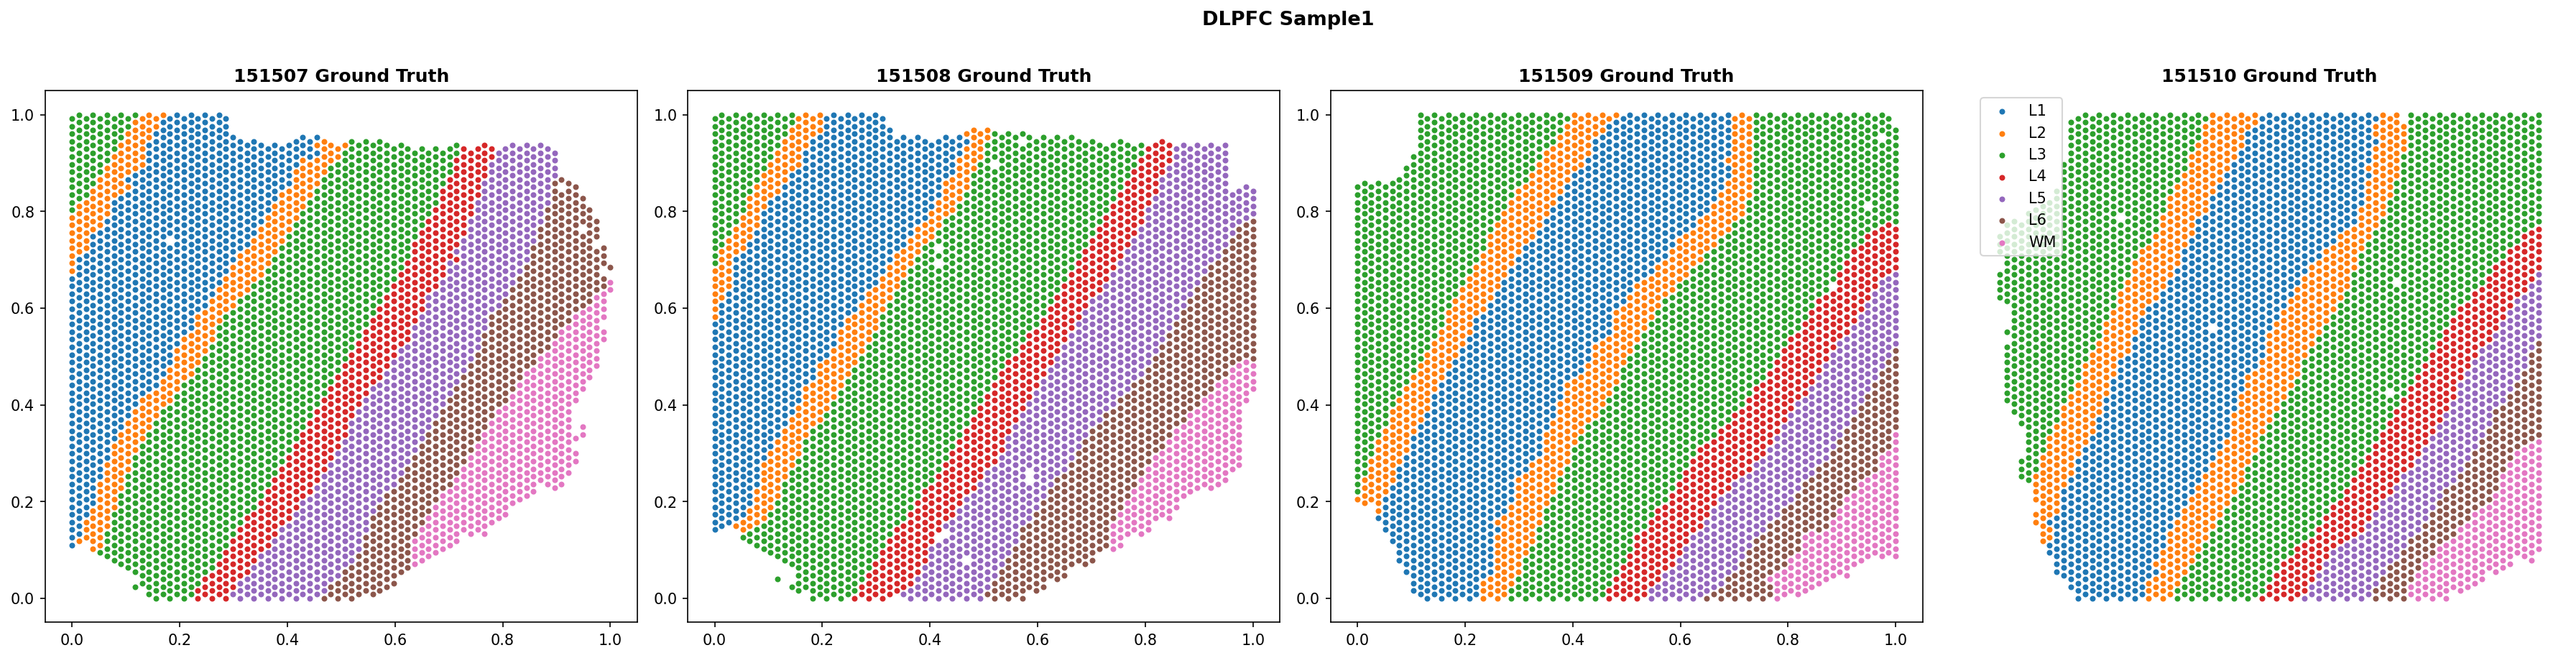


Plotting Sample1 individual slices...
Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots/ground_truth_151507.png


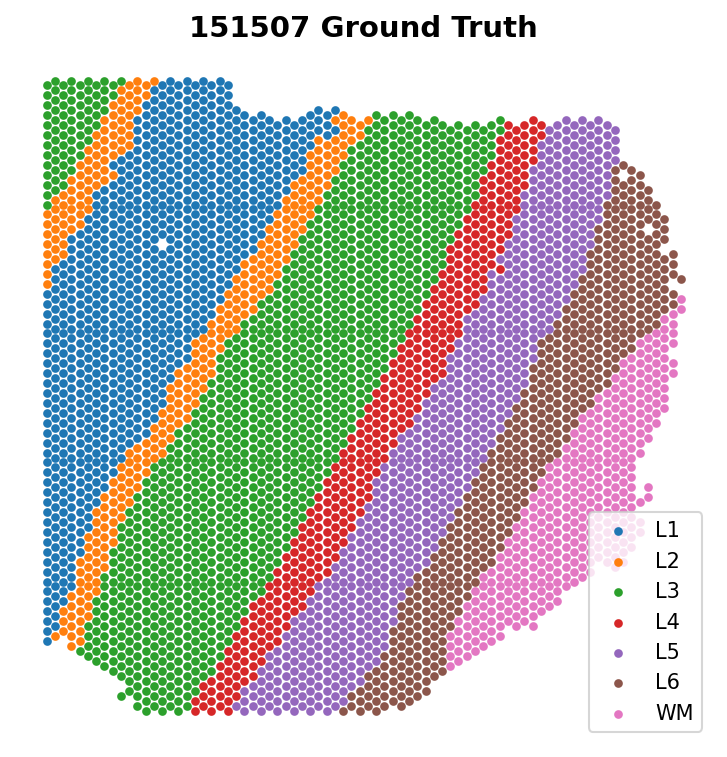

Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots/ground_truth_151508.png


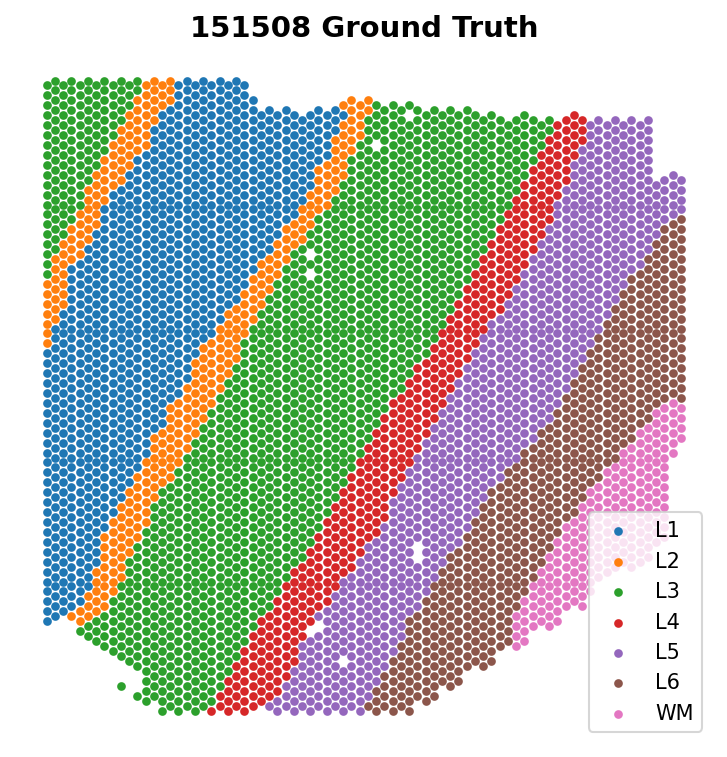

Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots/ground_truth_151509.png


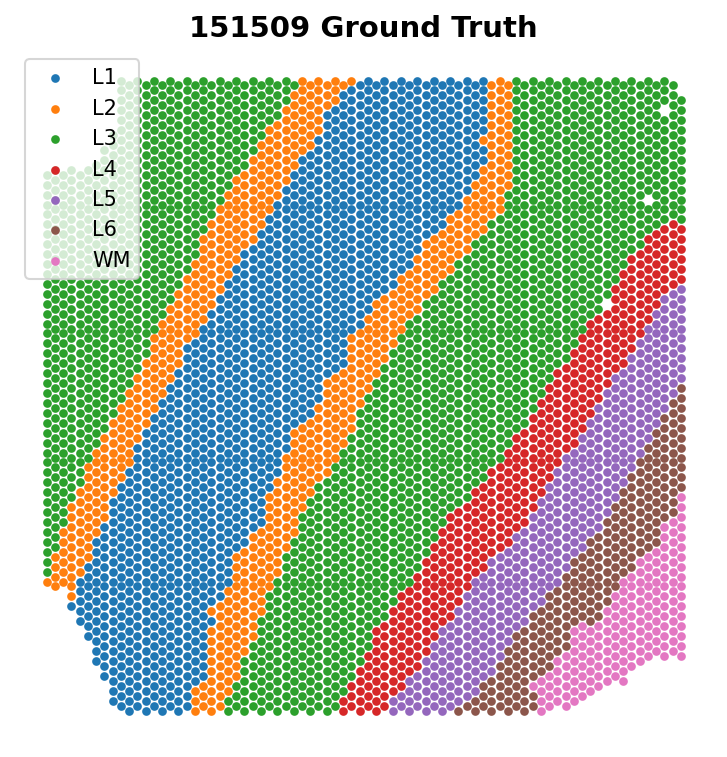

Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots/ground_truth_151510.png


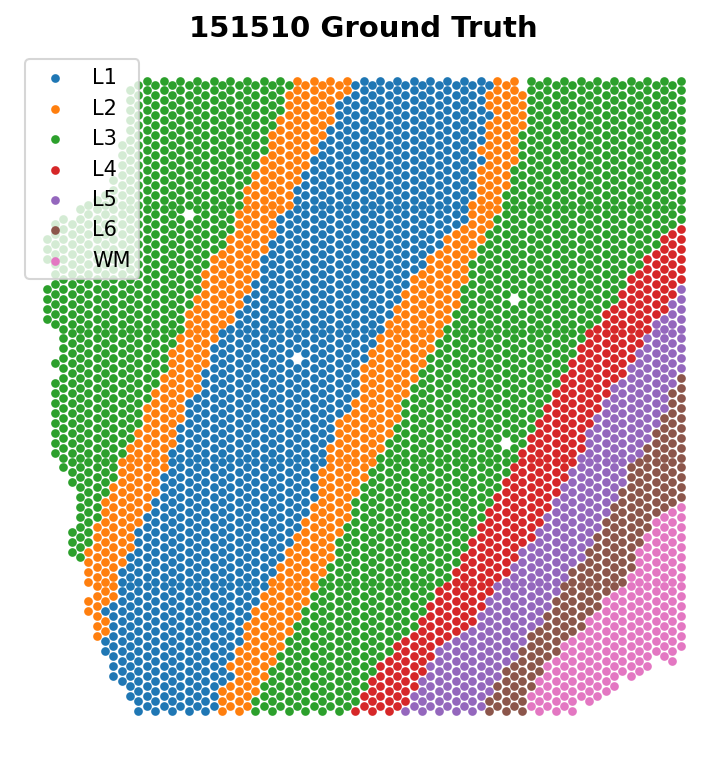


Sample1 ground truth plots complete.


In [6]:
# ============================================
# Part 6: Plot Sample1 ground truth
# ============================================

# 1×4 grid of all slices
sample1_grid_path = f'{OUTPUT_DIR}/sample1/ground_truth_plots/ground_truth_all_slices.png'
plot_ground_truth_grid(sample1_adata_dict, "Sample1", save_path=sample1_grid_path)

# Individual slice plots
print("\nPlotting Sample1 individual slices...")
for slice_id, adata in sample1_adata_dict.items():
    save_path = f'{OUTPUT_DIR}/sample1/ground_truth_plots/ground_truth_{slice_id}.png'
    plot_ground_truth_single(adata, slice_id, "Sample1", save_path=save_path)

print("\nSample1 ground truth plots complete.")

In [7]:
# ============================================
# Part 7: Load Sample3 data
# ============================================

print("Loading DLPFC Sample3 data...")
print("-" * 40)

sample3_adata_dict = {}
for slice_id in SAMPLE3_SLICES:
    print(f"Loading slice: {slice_id}")
    sample3_adata_dict[slice_id] = load_slice_data(slice_id, SAMPLE3_DATA_DIR)

print_slice_statistics(sample3_adata_dict, "Sample3")

Loading DLPFC Sample3 data...
----------------------------------------
Loading slice: 151673
Loading slice: 151674
Loading slice: 151675
Loading slice: 151676

DLPFC Sample3 — Data Summary

Slice 151673: 3611 spots
  Label distribution: {'L1': np.int64(273), 'L2': np.int64(253), 'L3': np.int64(989), 'L4': np.int64(218), 'L5': np.int64(673), 'L6': np.int64(692), 'WM': np.int64(513)}

Slice 151674: 3635 spots
  Label distribution: {'L1': np.int64(380), 'L2': np.int64(224), 'L3': np.int64(924), 'L4': np.int64(247), 'L5': np.int64(621), 'L6': np.int64(614), 'WM': np.int64(625)}

Slice 151675: 3566 spots
  Label distribution: {'L1': np.int64(328), 'L2': np.int64(275), 'L3': np.int64(771), 'L4': np.int64(275), 'L5': np.int64(732), 'L6': np.int64(533), 'WM': np.int64(652)}

Slice 151676: 3431 spots
  Label distribution: {'L1': np.int64(289), 'L2': np.int64(254), 'L3': np.int64(836), 'L4': np.int64(254), 'L5': np.int64(649), 'L6': np.int64(616), 'WM': np.int64(533)}

Total: 14243 spots


Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots/ground_truth_all_slices.png


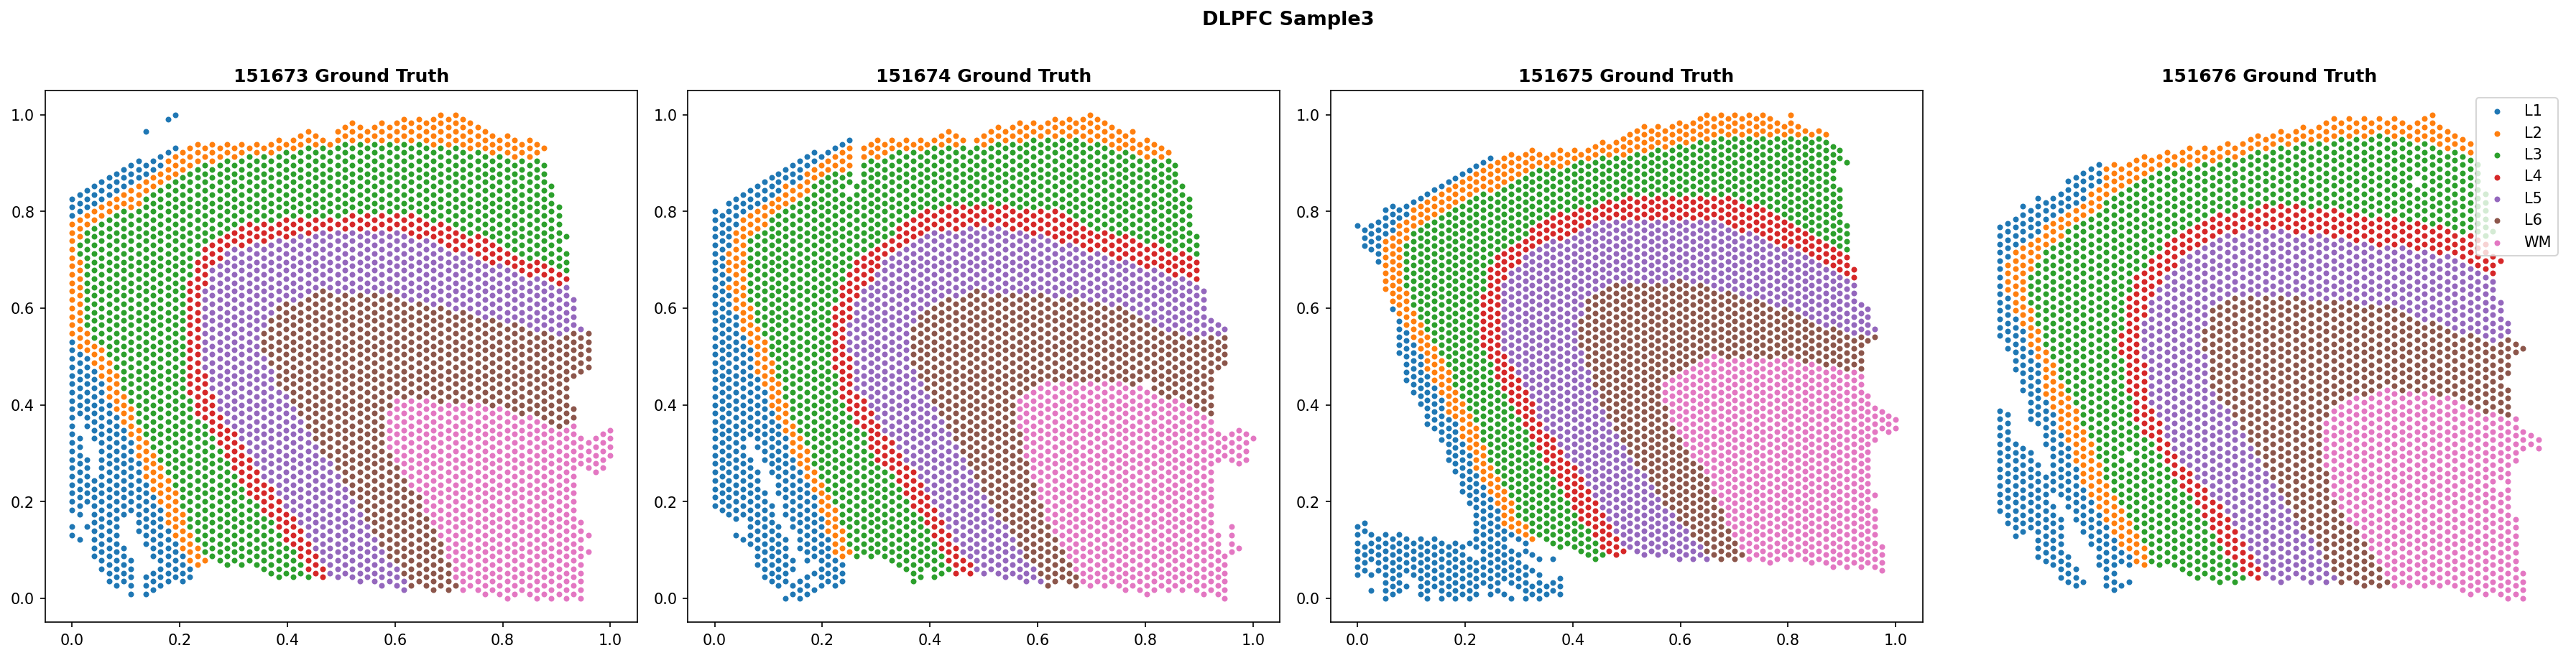


Plotting Sample3 individual slices...
Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots/ground_truth_151673.png


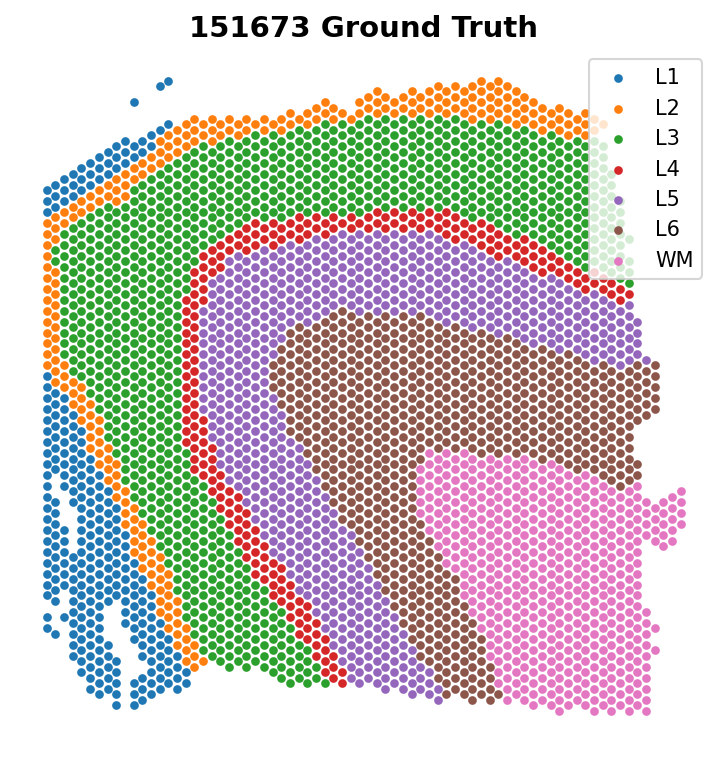

Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots/ground_truth_151674.png


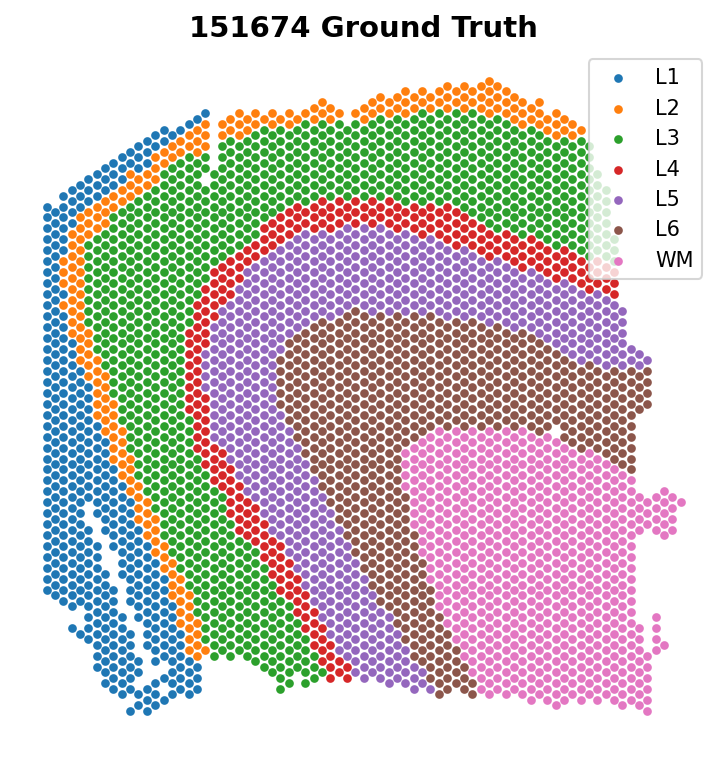

Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots/ground_truth_151675.png


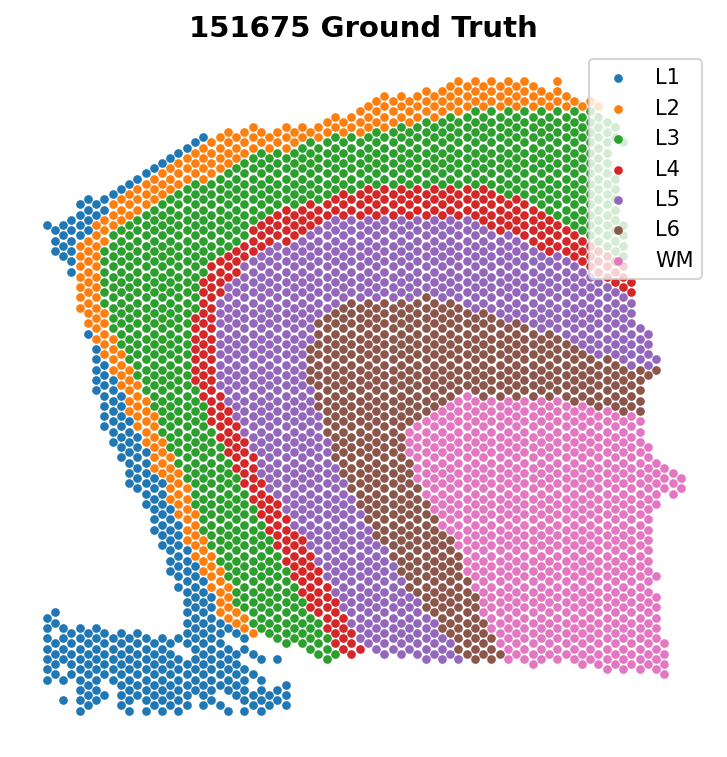

Saved: /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots/ground_truth_151676.png


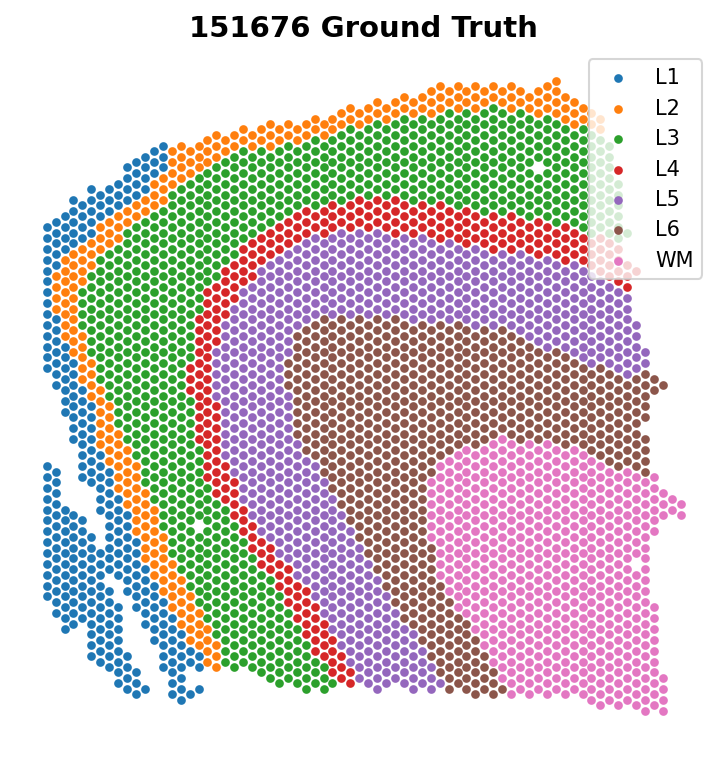


Sample3 ground truth plots complete.


In [8]:
# ============================================
# Part 8: Plot Sample3 ground truth
# ============================================

# 1×4 grid of all slices
sample3_grid_path = f'{OUTPUT_DIR}/sample3/ground_truth_plots/ground_truth_all_slices.png'
plot_ground_truth_grid(sample3_adata_dict, "Sample3", save_path=sample3_grid_path)

# Individual slice plots
print("\nPlotting Sample3 individual slices...")
for slice_id, adata in sample3_adata_dict.items():
    save_path = f'{OUTPUT_DIR}/sample3/ground_truth_plots/ground_truth_{slice_id}.png'
    plot_ground_truth_single(adata, slice_id, "Sample3", save_path=save_path)

print("\nSample3 ground truth plots complete.")

In [9]:
# ============================================
# Part 9: Summary and next steps
# ============================================

print("=" * 60)
print("Step 1 complete: data loading & ground truth visualization")
print("=" * 60)

print("\nGenerated files:")
print(f"  Sample1 plots : {OUTPUT_DIR}/sample1/ground_truth_plots/")
print(f"  Sample3 plots : {OUTPUT_DIR}/sample3/ground_truth_plots/")

print("\nData loaded in memory:")
print(f"  sample1_adata_dict : {list(sample1_adata_dict.keys())}")
print(f"  sample3_adata_dict : {list(sample3_adata_dict.keys())}")

print("\nGround truth label legend:")
print("  Layer_1 – Layer_6 : six cortical layers of DLPFC")
print("  WM                : White Matter")
print("  nan               : unannotated spots")

print("\n" + "=" * 60)
print("Next step: GLM-PCA dimensionality reduction")
print("=" * 60)

Step 1 complete: data loading & ground truth visualization

Generated files:
  Sample1 plots : /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample1/ground_truth_plots/
  Sample3 plots : /home/siruilf/A_new_dataset_for_gaston/DLPFC_gaston_outputs/sample3/ground_truth_plots/

Data loaded in memory:
  sample1_adata_dict : ['151507', '151508', '151509', '151510']
  sample3_adata_dict : ['151673', '151674', '151675', '151676']

Ground truth label legend:
  Layer_1 – Layer_6 : six cortical layers of DLPFC
  WM                : White Matter
  nan               : unannotated spots

Next step: GLM-PCA dimensionality reduction
